# Speech XAI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import Dataset
from IPython.display import display
import numpy as np 
import os
import pandas as pd
from pathlib import Path
from pydub import AudioSegment
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor


import warnings
warnings.filterwarnings('ignore')

## Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


from ferret import SpeechBenchmark, AOPC_Comprehensiveness_Evaluation_Speech, AOPC_Sufficiency_Evaluation_Speech

/home/moscato/miniconda3/envs/ferret-testing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchvision is not available - cannot save figures


## Data

In [3]:
dataset_name = 'FSC'
data_dir = f'{str(Path.home())}/data/speech/fluent_speech_commands_dataset'

# We read the test data of FSC dataset
df = pd.read_csv(f"{data_dir}/data/test_data.csv")
df["path"] = df["path"].apply(lambda x: os.path.join(data_dir, x))

dataset = Dataset.from_pandas(df)

## Models

In [4]:
# Note: set the ordinal of the device according to your system.
device_str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

print(device)

cuda:0


In [5]:
## Load model
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-ic"
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "superb/wav2vec2-base-superb-ic"
)

if torch.cuda.is_available():
    model = model.to(device)

Some weights of the model checkpoint at superb/wav2vec2-base-superb-ic were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-ic and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_em

## Speech-XAI: the `SpeechBenchmark` class

In [6]:
## Instantiate benchmark class
benchmark = SpeechBenchmark(model, feature_extractor, device=device_str)

In [7]:
## Example
# 'transcription': 'Turn up the bedroom heat.'
# 'action': 'increase'
# 'object': 'heat'
# 'location': 'bedroom'

idx = 136
audio_path = dataset[idx]['path']

audio = AudioSegment.from_wav(audio_path)
display(audio)

## Explain word importance

### Word importance

In [8]:
explanation = benchmark.explain(
    audio_path_or_array=audio_path, 
    methodology='LOO'
)

display(benchmark.show_table(explanation, decimals=3))

Transcribing audio to get word level timestamps...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.1+cu121. Bad things might happen unless you revert torch to 1.x.
Transcribed audio with whisperX into:  Turn up the bedroom heat.


,Turn,up,the,bedroom,heat.
action=increase,0.251,0.545,0.243,0.130,0.021
object=heat,-0.000,-0.000,-0.000,0.014,0.412
location=bedroom,0.002,0.006,0.082,0.997,0.242


In [9]:
explanation = benchmark.explain(
    audio_path_or_array=audio_path, 
    methodology='LIME'
)

display(benchmark.show_table(explanation, decimals=3))

Transcribing audio to get word level timestamps...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.1+cu121. Bad things might happen unless you revert torch to 1.x.
Transcribed audio with whisperX into:  Turn up the bedroom heat.


,Turn,up,the,bedroom,heat.
action=increase,0.155,0.273,0.117,0.281,0.149
object=heat,0.055,0.015,0.065,-0.007,0.211
location=bedroom,-0.065,-0.005,0.253,0.707,0.036


In [10]:
aopc_compr = AOPC_Comprehensiveness_Evaluation_Speech(benchmark.model_helper)
evaluation_output_c = aopc_compr.compute_evaluation(explanation)

aopc_suff = AOPC_Sufficiency_Evaluation_Speech(benchmark.model_helper)
evaluation_output_s = aopc_suff.compute_evaluation(explanation)

evaluation_output_c, evaluation_output_s

(EvaluationSpeech(name='aopc_compr_speech', score=[0.8124997764127329, 0.14093613624572754, 0.9970740624897493], target=[3, 4, 2]),
 EvaluationSpeech(name='aopc_suff', score=[0.624854679661803, 0.01358117163181305, 0.10568535327911377], target=[3, 4, 2]))

## Explain paralinguistic impact

In [24]:
explain_table = benchmark.explain(
    audio_path_or_array=audio_path,
    methodology='perturb_paraling',
)
display(benchmark.show_table(explain_table, decimals=2))

Perturbation type: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:28<00:00,  3.61s/it]


,pitch shifting,pitch shifting down,pitch shifting up,time stretching,time stretching down,time stretching up,reverberation,noise
action=increase,0.08,0.04,0.13,0.11,0.19,0.04,0.63,0.44
object=heat,0.02,-0.00,0.04,0.00,0.00,0.00,0.00,0.29
location=bedroom,0.22,0.13,0.33,0.02,0.03,0.01,0.34,0.60


## Show variation

In [27]:
perturbation_types = ['time stretching', 'pitch shifting', 'reverberation', 'noise']
variations_table = benchmark.explain_variations(
    audio_path_or_array=audio_path,
    current_sr=16e3,
    perturbation_types=perturbation_types
)

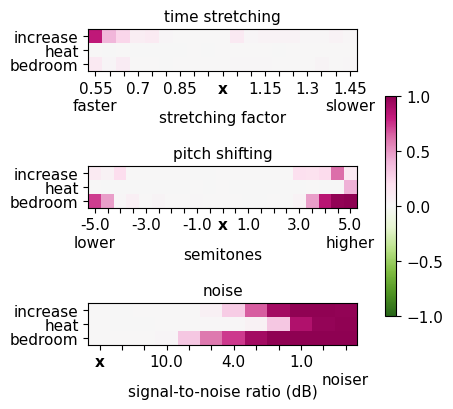

In [28]:
variations_table_plot = {k:variations_table[k] for k in variations_table if k in ['time stretching', 'pitch shifting', 'noise']}
fig = benchmark.plot_variations(variations_table_plot, show_diff = True, figsize=(4.6, 4.2));
# fig.savefig(f'example_{dataset_name}_context.pdf', bbox_inches='tight')